# AWS SageMaker Tutorial Part 2
https://smusg.udemy.com/course/build-an-aws-machine-learning-pipeline-for-object-detection/learn/lecture/36969246#overview
-	https://github.com/patrikszepesi/EcoAI (MERN app code)
-	https://github.com/patrikszepesi/MachineLearningSourceCodeCourse2 (ML code)


# Collab Shortcuts
Moving / Creating / Deleting
*   move cell up ctrl+m K
*   move cell down ctrl+m J
*   create a new cell above ctrl+m a
*   create a new cell below ctrl+m b
*   delete a cell ctrl+m d

Conversion
*   convert a text cell to code cell ctrl + m + y
*   convert a code cellt o text cell ctrl + m + m (double tap m)

Find and Replace
*   find and replace within cell ctrl + shift + h
*   find and replace within entire notebook ctrl + h

Running code
*   ctrl + enter to run current cell
*   alt + Enter to run current cell and create new cell below
*   ctrl + shift + enter to run selection




```
# ctrl + m + i to interrupt m
# ctrl + m + l to toggle line numbers
# ctrl + m + o to toggle output
print ('1')
```


# Data Loading
Taken from https://storage.googleapis.com/openimages/web/download_v7.html

Loading the data previously downloaded from Part 1

In [2]:
import zipfile
import os

zip_file_paths = ['trainImages.zip', 'valImages.zip']
for path in zip_file_paths:
    with zipfile.ZipFile(path, 'r') as zip_ref:
        # zip_ref.extractall('.')

        # Create unzipped folder containing the same name as the zip file
        name = str(path)
        zip_ref.extractall(f'unzipped/{name.split(".")[0]}')

In [3]:
import pandas as pd

df_train = pd.read_csv('unzipped/trainImages/labels/detections.csv')
df_train.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938


In [4]:
df_val = pd.read_csv('unzipped/valImages/labels/detections.csv')
df_val.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964201,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0


Due to the large size of the csv, switch / use "ml.t3.2xlarge" 8vCPU 32GB memory instance instead of "ml.t3.medium" 2vCPU 4GB (avoid kernel failure / long loading). Be aware this will increase the runtime costs!

For JupyterLab, the space has to be closed before the instance type and resource allocation can be changed. 

In [5]:
print(len(df_train))
print(len(df_val))

14610229
303980


'classes.csv' within Metadata in the trainImages and valImages folders shows which each label correspond to what items / names. The following code checks that the class taxonomy is the same for both training and validation images, specifically for the 'Plastic bag' chosen for this tutorial.

In [6]:
train_class_df = pd.read_csv('unzipped/trainImages/metadata/classes.csv', names=['LabelName', 'Object'])
val_class_df = pd.read_csv('unzipped/valImages/metadata/classes.csv', names=['LabelName', 'Object'])

train_identifier_df = train_class_df[train_class_df['Object'] == 'Plastic bag'] 
val_identifier_df = val_class_df[val_class_df['Object'] == 'Plastic bag'] 

print(f"{train_identifier_df}\n")
print(f"{val_identifier_df}\n")

     LabelName       Object
327  /m/05gqfk  Plastic bag

     LabelName       Object
327  /m/05gqfk  Plastic bag



In [9]:
folder_path_train = 'unzipped/trainImages'
folder_path_val = 'unzipped/valImages'

In [10]:
import glob

def clean_dataframe(df_for_train,df_for_validation):
    # List image files in the train and val folders
    train_images = glob.glob(folder_path_train + '/data/*.jpg')
    val_images = glob.glob(folder_path_val + '/data/*.jpg')
    
    # Extract ImageIDs from the file names
    train_image_ids = {os.path.basename(path)[:16] for path in train_images} # 16 characters before the file extension is the ImageID. Example: '000002b66c9c498e.jpg' from the full file path '/content/drive/My Drive/Colab Notebooks/CS231N Project/data/train/data/000002b66c9c498e.jpg'
    val_image_ids = {os.path.basename(path)[:16] for path in val_images}
    
    # Filter the DataFrames
    df_train_cleansed = df_train[(df_train['LabelName'] == '/m/05gqfk') & (df_train['ImageID'].isin(train_image_ids))]
    df_val_cleansed = df_val[(df_val['LabelName'] == '/m/05gqfk') & (df_val['ImageID'].isin(val_image_ids))]
    
    return df_train_cleansed, df_val_cleansed

df_train_cleansed, df_val_cleansed = clean_dataframe(df_train, df_val)

In [11]:
# def clean_dataframe(df_for_train,df_for_validation):
#     df_train_cleansed = df_train[df_train['LabelName'].str.contains('/m/05gqfk')]
#     df_val_cleansed = df_val[df_val['LabelName'].str.contains('/m/05gqfk')]

#     return df_train_cleansed, df_val_cleansed

# df_train_cleansed, df_val_cleansed = clean_dataframe(df_train, df_val)

In [17]:
print(f"Count of segmentations in train: {len(df_train_cleansed)}")
print(f"Count of segmentations in train: {len(df_val_cleansed)}")

display(df_train_cleansed.head())

Count of segmentations in train: 173
Count of segmentations in train: 9


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
8282,0005a922e055c723,xclick,/m/05gqfk,1,0.000000,0.999375,0.000000,0.998889,0,1,...,0,0,0.546875,0.700000,0.000000,0.999375,0.000000,0.998889,0.000000,0.593333
8733,000610ca2148a5ec,xclick,/m/05gqfk,1,0.163227,0.811445,0.051875,0.936875,0,0,...,0,0,0.740150,0.163227,0.811445,0.811445,0.051875,0.161250,0.936875,0.936875
10247,00075e339f3d4f37,xclick,/m/05gqfk,1,0.017578,0.999023,0.000000,0.998529,0,1,...,0,0,0.263672,0.999023,0.516602,0.017578,0.000000,0.107353,0.998529,0.385294
12496,00097c09aca0cabf,xclick,/m/05gqfk,1,0.112000,0.634000,0.000000,0.909414,1,1,...,0,0,0.355000,0.634000,0.325000,0.112000,0.000000,0.390764,0.909414,0.600355
40914,002c60d5fbc94244,xclick,/m/05gqfk,1,0.375000,0.461250,0.646993,0.772829,0,0,...,0,0,0.433125,0.375000,0.461250,0.457500,0.646993,0.755011,0.766147,0.772829


In [24]:
print(f"Count of unique images in train: {len(set(df_train_cleansed['ImageID']))}")
print(f"Count of unique images in train: {len(set(df_val_cleansed['ImageID']))}")

Count of unique images in train: 100
Count of unique images in train: 9


In [18]:
# Define the directory and file paths
directory = 'unzipped/trainImages/metadata'
train_csv_path = os.path.join(directory, 'train_class.csv')

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the DataFrames to CSV files
df_train_cleansed.to_csv(train_csv_path, index=False)


directory = 'unzipped/valImages/metadata'
val_csv_path = os.path.join(directory, 'val_class.csv')
os.makedirs(directory, exist_ok=True)
df_val_cleansed.to_csv(val_csv_path, index=False)

print(f"Training data saved to {train_csv_path}")
print(f"Validation data saved to {val_csv_path}")

Training data saved to unzipped/trainImages/metadata/train_class.csv
Validation data saved to unzipped/valImages/metadata/val_class.csv


With the classes.csv trimmed, you can switch back to the cheaper "ml.t3.medium" instance. Avoid running the above Data Loading Code and skip to the upcoming section from now on.

# Data Splitting

In [1]:
folder_path_train = 'unzipped/trainImages'
folder_path_val = 'unzipped/valImages'

In [2]:
import pandas as pd

df_train = pd.read_csv(folder_path_train + '/metadata/train_class.csv')
display(df_train.head())
display(df_train.info())

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0005a922e055c723,xclick,/m/05gqfk,1,0.000000,0.999375,0.000000,0.998889,0,1,...,0,0,0.546875,0.700000,0.000000,0.999375,0.000000,0.998889,0.000000,0.593333
1,000610ca2148a5ec,xclick,/m/05gqfk,1,0.163227,0.811445,0.051875,0.936875,0,0,...,0,0,0.740150,0.163227,0.811445,0.811445,0.051875,0.161250,0.936875,0.936875
2,00075e339f3d4f37,xclick,/m/05gqfk,1,0.017578,0.999023,0.000000,0.998529,0,1,...,0,0,0.263672,0.999023,0.516602,0.017578,0.000000,0.107353,0.998529,0.385294
3,00097c09aca0cabf,xclick,/m/05gqfk,1,0.112000,0.634000,0.000000,0.909414,1,1,...,0,0,0.355000,0.634000,0.325000,0.112000,0.000000,0.390764,0.909414,0.600355
4,002c60d5fbc94244,xclick,/m/05gqfk,1,0.375000,0.461250,0.646993,0.772829,0,0,...,0,0,0.433125,0.375000,0.461250,0.457500,0.646993,0.755011,0.766147,0.772829


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      173 non-null    object 
 1   Source       173 non-null    object 
 2   LabelName    173 non-null    object 
 3   Confidence   173 non-null    int64  
 4   XMin         173 non-null    float64
 5   XMax         173 non-null    float64
 6   YMin         173 non-null    float64
 7   YMax         173 non-null    float64
 8   IsOccluded   173 non-null    int64  
 9   IsTruncated  173 non-null    int64  
 10  IsGroupOf    173 non-null    int64  
 11  IsDepiction  173 non-null    int64  
 12  IsInside     173 non-null    int64  
 13  XClick1X     173 non-null    float64
 14  XClick2X     173 non-null    float64
 15  XClick3X     173 non-null    float64
 16  XClick4X     173 non-null    float64
 17  XClick1Y     173 non-null    float64
 18  XClick2Y     173 non-null    float64
 19  XClick3Y

None

In [3]:
df_val = pd.read_csv(folder_path_val + '/metadata/val_class.csv')
display(df_val.head())
display(df_val.info())

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,1602934b52b119cc,xclick,/m/05gqfk,1,0.000000,1.000000,0.000000,1.00000,1,0,1,0,0
1,488ab15e2780bec9,xclick,/m/05gqfk,1,0.000000,1.000000,0.023599,1.00000,0,0,1,0,0
2,4e24222b68123ef3,xclick,/m/05gqfk,1,0.377083,0.745833,0.778125,0.96875,0,0,0,0,0
3,527bec033e8298a5,xclick,/m/05gqfk,1,0.107813,0.995313,0.106250,0.99375,0,0,0,0,0
4,7e25a4a33611d933,xclick,/m/05gqfk,1,0.000000,1.000000,0.000000,1.00000,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      9 non-null      object 
 1   Source       9 non-null      object 
 2   LabelName    9 non-null      object 
 3   Confidence   9 non-null      int64  
 4   XMin         9 non-null      float64
 5   XMax         9 non-null      float64
 6   YMin         9 non-null      float64
 7   YMax         9 non-null      float64
 8   IsOccluded   9 non-null      int64  
 9   IsTruncated  9 non-null      int64  
 10  IsGroupOf    9 non-null      int64  
 11  IsDepiction  9 non-null      int64  
 12  IsInside     9 non-null      int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 1.0+ KB


None

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size = 0.2, random_state = 42)
display(train.head())
display(test.head())

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
154,09c07b24d4672ea2,xclick,/m/05gqfk,1,0.015000,0.238125,0.607759,0.921336,1,0,...,1,0,0.194375,0.015000,0.161250,0.238125,0.607759,0.766164,0.921336,0.622845
136,079cab48c40308b5,xclick,/m/05gqfk,1,0.668125,0.793125,0.093333,0.303333,1,0,...,0,0,0.725000,0.668125,0.771250,0.793125,0.093333,0.138333,0.303333,0.217500
147,089b1550d7b264b5,xclick,/m/05gqfk,1,0.203333,0.886667,0.185000,0.912500,0,0,...,0,0,0.216667,0.203333,0.881667,0.886667,0.185000,0.912500,0.876875,0.220625
51,011d3ecef79d91ad,activemil,/m/05gqfk,1,0.292500,0.549375,0.297373,0.960600,-1,-1,...,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
126,073dd5489a8faed7,xclick,/m/05gqfk,1,0.384375,0.468750,0.456250,0.704167,1,0,...,0,0,0.404687,0.384375,0.468750,0.431250,0.456250,0.579167,0.629167,0.704167


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
162,09f9fb6ef25b1eda,activemil,/m/05gqfk,1,0.202614,0.764706,0.264706,0.921569,-1,-1,...,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
42,00dabf1d5d5863ba,xclick,/m/05gqfk,1,0.591250,0.777500,0.263245,0.801324,1,0,...,0,0,0.638750,0.591250,0.777500,0.676250,0.263245,0.412252,0.413907,0.801324
90,03b3f942b2c2b0e8,activemil,/m/05gqfk,1,0.084375,0.334375,0.229167,0.480000,-1,-1,...,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
60,01381a0300454d75,xclick,/m/05gqfk,1,0.603125,0.688750,0.362500,0.434167,1,0,...,0,0,0.665625,0.603125,0.688750,0.641875,0.362500,0.412500,0.424167,0.434167
114,0602604499b9c09d,xclick,/m/05gqfk,1,0.368750,0.676562,0.721120,0.998833,1,0,...,0,0,0.483594,0.368750,0.676562,0.664844,0.721120,0.877480,0.977830,0.998833


In [5]:
train_ids = train["ImageID"].values.tolist()
print("Count of segmentations in train:", len(train_ids))
print("-------------------------------")
test_ids = test["ImageID"].values.tolist()
print("Count of segmentations in test:", len(test_ids))

Count of segmentations in train: 138
-------------------------------
Count of segmentations in test: 35


In [6]:
folder_path_train = 'unzipped/trainImages'
folder_path_test = 'unzipped/testImages'
folder_path_val = 'unzipped/valImages'

In [7]:
import os.path
from os import path

# Create folder for test images
path = folder_path_test
# os.mkdir(path) # will fail if the folder already exists
os.makedirs(path, exist_ok=True)

path = folder_path_test + "/data"
os.makedirs(path, exist_ok=True)

In [8]:
import shutil
import glob

to_loop = 'unzipped/trainImages/data/*.jpg'
folder = glob.glob(to_loop)

new_path = 'unzipped/testImages/data'

# Move / Copy images from train data folder to test. 
# Copy if an image has segmentations in both train and test
# Else simply move the entire image over to test
for path in folder:
    id = path[26:42]
    if ((id in test_ids) and (id in train_ids)):
        shutil.copy(path, f"{new_path}/{id}.jpg")
    elif ((id in test_ids) and (id not in train_ids)):
        shutil.move(path, f"{new_path}/{id}.jpg")

In [9]:
train_images = os.listdir(folder_path_train + '/data')
print(f"There are {len(train_images)} images in {folder_path_train}")

test_images = os.listdir(folder_path_test + '/data')
print(f"There are {len(test_images)} images in {folder_path_test}")

train_test_images = set(train_ids).intersection(test_ids)
print(f"There are {len(train_test_images)} images in both {folder_path_train} and {folder_path_test}")

print(f"{len(train_images)} + {len(test_images)} = {len(train_images) + len(test_images)} images")

There are 87 images in unzipped/trainImages
There are 25 images in unzipped/testImages
There are 12 images in both unzipped/trainImages and unzipped/testImages
87 + 25 = 112 images


# Data Visualisation

In [10]:
folder_path_train = 'unzipped/trainImages'
folder_path_test = 'unzipped/testImages'
folder_path_val = 'unzipped/valImages'

In [12]:
import glob # recursive file search library

folder_paths = [folder_path_train, folder_path_test, folder_path_val]
for folder_path in folder_paths:
    counter = 0
    folder = glob.glob(folder_path + '/data/*.jpg')

    for i in folder:
        counter += 1
    print("There are", counter, "images in", folder_path)

There are 87 images in unzipped/trainImages
There are 25 images in unzipped/testImages
There are 9 images in unzipped/valImages


In [15]:
# Get images ids. The image ids are the names of the images without the extension
train_list_ids = []
val_list_ids = []

def get_ids (split, print_this, to_append_list):
    start, end = 0, 0
    if split == folder_path_train:
        start, end = 26, 42 # get the image name from the 26 to 41 character of the path 'unzipped/trainImages/data/*.jpg'
    elif split == folder_path_val:
        start, end = 24, 40 # get the image name from the 24 to 39 character of the path 'unzipped/valImages/data/*.jpg'
    else:
        raise Exception("Invalid parameter")
    folder = split 
    img_paths = glob.glob(folder + '/data/*.jpg')
    img_ids = to_append_list
    
    for i in img_paths:
        img_ids.append(i[start:end])
    print(len(img_ids))
    print(print_this, img_ids[:5])
    print()

In [16]:
get_ids(folder_path_train, "Train images ids sample: ", train_list_ids)
get_ids(folder_path_val, "Validation images ids sample: ", val_list_ids)

87
Train images ids sample:  ['0b02ca412549020e', '04c620141ea4ca83', '011c2e4461eb1fdc', '0224e7521bba044c', '08a6765baa7c3b1a']

9
Validation images ids sample:  ['ecd5fc22a65b8d32', '1602934b52b119cc', '527bec033e8298a5', '488ab15e2780bec9', '4e24222b68123ef3']



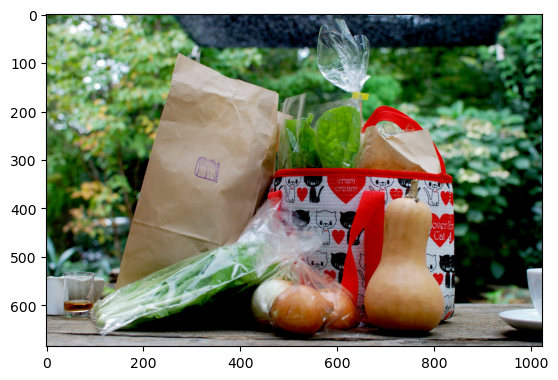

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random

def visualise_random_image(split_name):
    split_path = folder_path_train if split_name == "train" else folder_path_val if split_name == "val" else 0
    if split_path == 0:
        raise Exception("Invalid split name, must be either train or val")
    image_folder = split_path

    image_paths = glob.glob(image_folder + "/data/*.jpg")
    num_of_images = len(image_paths)
    random_int = random.randint(0,num_of_images -1)
    random_image = image_paths[random_int]
    img = mpimg.imread(random_image)
    
    # create the figure and axes and show them
    # plt.imshow() is used to display images, while plt.show() is used to display general plots and figures.
    fig,ax = plt.subplots()
    ax.imshow(img)
    plt.imshow(img)
    plt.show()
    
visualise_random_image("train")

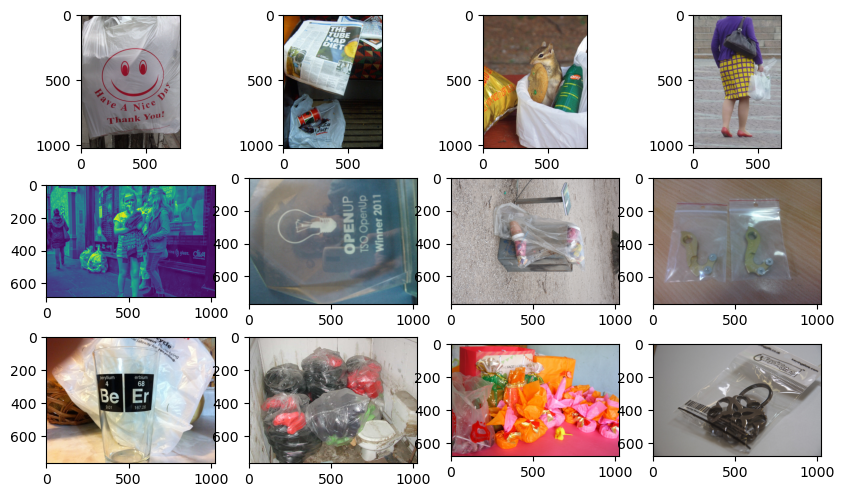

In [29]:
fig = plt.figure(figsize=(10,10))
columns = 4
rows = 5

# validation_images_path = ""#9
# train_images_path = ""#517
                      
def visualize_many(from_num, to_num, split_name):
    dataset_path = folder_path_train if split_name == 'train' else folder_path_val if split_name == 'validation' else 0
    if dataset_path == 0:
        raise Exception("Invalid input parameter, must be either train or validation")
    images_paths = glob.glob(dataset_path + "/data/*.jpg")
    
    index_counter = 1
    for i in range(from_num, to_num):
        counter = i
        image = images_paths[counter]
        img = mpimg.imread(image)
        fig.add_subplot(rows, columns, index_counter)
        plt.imshow(img)
        index_counter +=1
    plt.show()

    
visualize_many(0,12,"train")

0.029687 0.595312 0.135937 0.546875
30.399488 609.599488 139.199488 560.0


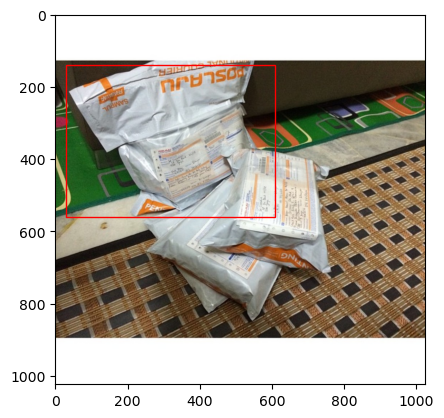

0.37708333 0.74583334 0.778125 0.96875
289.59999744 572.80000512 796.8 992.0


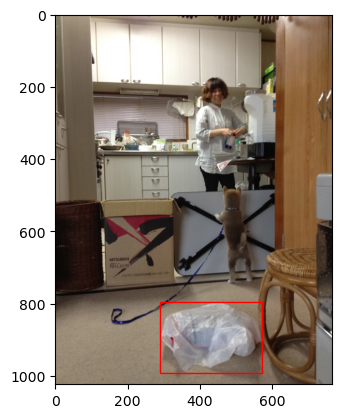

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import random
import glob
from PIL import Image

validation_images_path = ""#9
train_images_path = ""#517


def visualize_bb(dataset):
    folder_path = folder_path_train if dataset == 'train' else folder_path_val if dataset == 'val' else 0
    images_path = folder_path + "/data/*.jpg"
    if dataset == 0:
        raise Exception("Invalid input parameter, must be either train or validation")
    
    start = 0
    end = 0
    
    if dataset == 'train':
        start, end, df, split = 26, 42, df_train, "trainImages"
    elif dataset == 'val':
        start, end, df, split = 24, 40, df_val, "validationImages"
    else:
        raise Exception("Invalid parameter")
    
    image_folder = images_path
    images_paths = glob.glob(image_folder)
    num_of_images = len(images_paths)
    random_int = random.randint(0, num_of_images -1)
    random_image = images_paths[random_int]
    #print(random_image)
    img = Image.open(random_image)
    id_of_image = random_image[start:end]
    
    df_rows = df.loc[(df.ImageID == id_of_image) & (df.LabelName == '/m/05gqfk')]
    
    image_width, image_height = img.size
    
    fig, ax = plt.subplots()
    ax.imshow(img)

    for index, row in df_rows.iterrows():
        print(row['XMin'], row['XMax'], row['YMin'], row['YMax'])
        
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        
        new_xmin = xmin * image_width
        new_xmax = xmax * image_width
        new_ymin = ymin * image_height
        new_ymax = ymax * image_height
        print(new_xmin,new_xmax,new_ymin,new_ymax)
        
        width = new_xmax - new_xmin
        height = new_ymax - new_ymin
        
        rect = patches.Rectangle((new_xmin,new_ymin), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
    plt.show()
    
visualize_bb("train")
visualize_bb("val")


# MXNet, RecordIO
Mxnet is an open source deep learning framework that allows you to define, train and deploy deep neural networks on a wide array of devices from cloud infrastructure to mobile devices.

It's highly scalable and it allows for fast model training and supports a flexible programming model and multiple languages. It's similar to TensorFlow, but AWS uses Mxnet for their built-in algorithms as it is faster and integrates better with cloud infrastructure.

RecordIO is a file format for efficiently storing and reading large amounts of binary data, such as images, in a sequential manner. It is used in image processing to enable fast and efficient data access and processing, which is crucial for handling large datasets commonly encountered in machine learning applications. For more Information, refer to https://mesos.apache.org/documentation/latest/recordio/

<b>We'll trimmed the cleaned csv to contain just the relevent columns, then convert them into LST files and then we can convert that into record IOs.</b>

```
# <index> <header_col> <label_width> <class> <xmin> <ymin> <xmax> <ymax> <relative/path/to/image>
# 222 2 5 0.000 0.4 0.3 0.9 0.44 path/to/image11.jpg
# 222 2 5 1.000 0.5 0.2 0.33 0.8 path/to/image11.jpg
```
the header col denotes how RecordIO will take in the upcoming parameters. 2 is set as due to how the "data table" containing 2 headers, the header_col itself and the label_width. Not very essential to understand how it works, but still important to set correctly.

the label width represents the 5 upcoming parameters that will be inputted:
* class
* xmin
* ymin
* xmax
* ymax

0.000 is our plastic bag identifier. So if the algorithm sees an input that has 0.000, it's going to know that it belongs to Plastic bags. 3 decimals is necessary due to how the algorithm is  coded.

0.4, 0.30.90.44 are the bounding box information (xmin, ymin, xmax, ymax)

<center><img src="img/MXNet 00.png"/></center>
<p style="text-align: center">
    <b>Documentation for MXNet</b>
</p><br>